In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
import yfinance as yf
from pandas_datareader import data as pdr
from scipy.optimize import curve_fit
import statsmodels.api as sm
from scipy.optimize import minimize

In [30]:
# Function to get historical US Treasury yields from FRED
def get_yield_data():
    symbols = [
        "DGS1MO", "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3", "DGS5", "DGS7", "DGS10", "DGS20", "DGS30"
    ]
    df = pdr.get_data_fred(symbols, start="2020-01-01", end="2024-01-01")
    df.dropna(inplace=True)
    return df

# Nelson-Siegel yield curve model
def nelson_siegel(params, maturities):
    beta0, beta1, beta2, tau = params
    term = maturities / tau
    return beta0 + beta1 * (1 - np.exp(-term)) / term + beta2 * ((1 - np.exp(-term)) / term - np.exp(-term))

# Error function for curve fitting
def ns_error(params, maturities, yields):
    return np.sum((yields - nelson_siegel(params, maturities))**2)

# Fit Nelson-Siegel model to yield data
def fit_nelson_siegel(yields, maturities):
    initial_params = [0.02, -0.02, 0.02, 2.0]
    result = minimize(ns_error, initial_params, args=(maturities, yields), method='L-BFGS-B')
    return result.x

# Trading Strategy: Butterfly Spread (captures yield curve curvature changes)
def butterfly_spread(yields):
    return 2 * yields["DGS5"] - (yields["DGS2"] + yields["DGS10"])

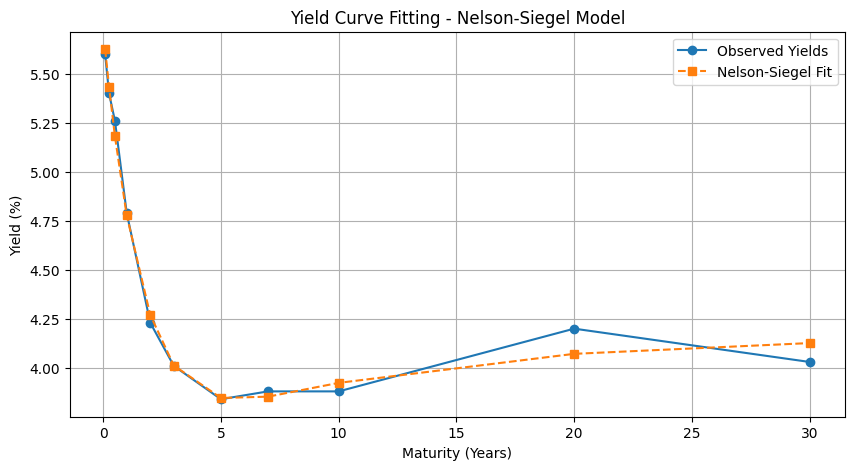

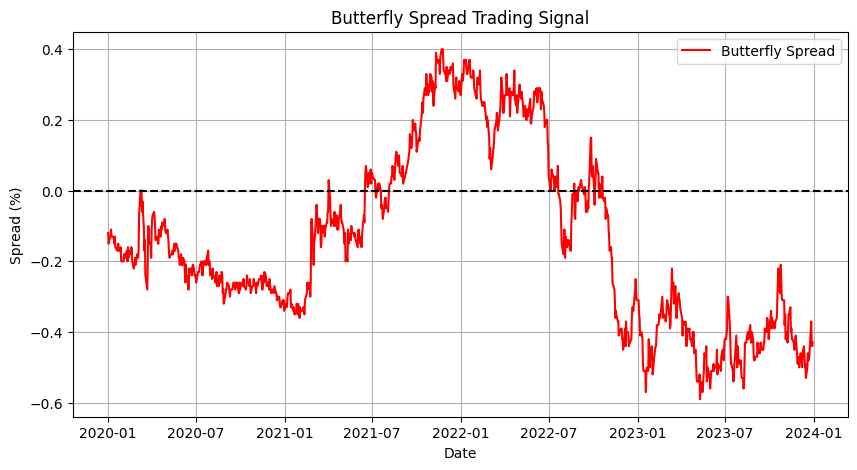

In [31]:
# Main Execution
if __name__ == "__main__":
    # Get yield data
    yield_data = get_yield_data()
    maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])   # 
    
    # Fit Nelson-Siegel model
    latest_yields = yield_data.iloc[-1].values
    ns_params = fit_nelson_siegel(latest_yields, maturities)
    fitted_yields = nelson_siegel(ns_params, maturities)
    
    # Plot the yield curve
    plt.figure(figsize=(10, 5))
    plt.plot(maturities, latest_yields, 'o-', label='Observed Yields')
    plt.plot(maturities, fitted_yields, 's--', label='Nelson-Siegel Fit')
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Yield (%)")
    plt.legend()
    plt.title("Yield Curve Fitting - Nelson-Siegel Model")
    plt.grid()
    plt.show()
    
    # Compute Butterfly Spread Trading Signal
    yield_data['Butterfly_Spread'] = butterfly_spread(yield_data)
    
    # Plot Butterfly Spread over time
    plt.figure(figsize=(10, 5))
    plt.plot(yield_data.index, yield_data['Butterfly_Spread'], label='Butterfly Spread', color='red')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Spread (%)")
    plt.legend()
    plt.title("Butterfly Spread Trading Signal")
    plt.grid()
    plt.show()